## Look Before You Leap 

Re-implementation of [*Look Before You Leap: A Universal Emergent Decomposition of Retrieval Tasks in Language Models*](https://arxiv.org/abs/2312.10091).

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
from transformers import GPTNeoXForCausalLM, AutoTokenizer, AutoModelForCausalLM
from jaxtyping import Float, Int
from typing import List, Optional, Tuple, Dict
import sys
from functools import partial
from tqdm import tqdm
import json
import seaborn as sns
import pandas as pd

from activations import get_residual_stream_activations, get_layers_to_enumerate, apply_activation_patch
from plots import plot_request_patching_accuracy

import warnings

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device =', device)
torch.set_grad_enabled(False)

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

else:
    print("CUDA is not available. Listing CPUs instead.")
    print(torch.__version__)

/home/jeanne/Documents/Athena/athena_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = cpu
CUDA is not available. Listing CPUs instead.
2.2.0+cu121


Number of stories: 5
Number of requests: 2


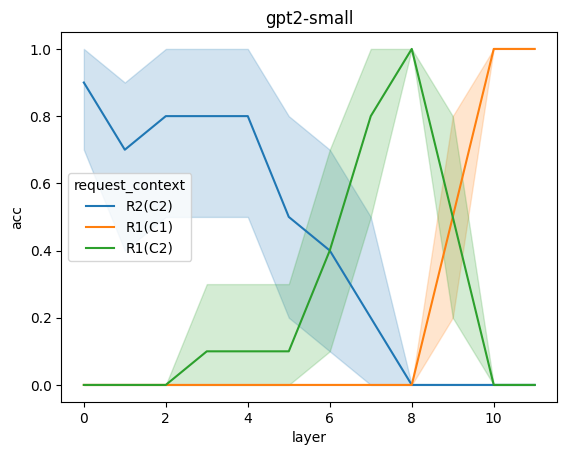

In [2]:
warnings.filterwarnings("ignore")
fig = plot_request_patching_accuracy(model_name='gpt2-small',
                                     savefig=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Number of stories: 5
Number of requests: 2


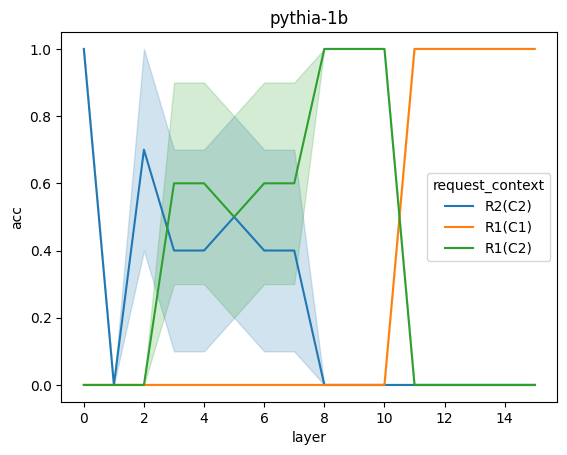

In [3]:
fig = plot_request_patching_accuracy(model_name='pythia-1b',
                                     savefig=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Number of stories: 5
Number of requests: 2


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 198, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.

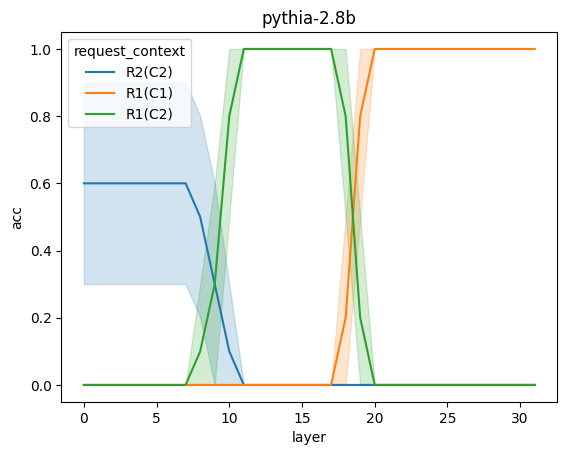

In [ ]:
fig = plot_request_patching_accuracy(model_name='pythia-2.8b',
                                     savefig=True)

### Broken-down pipeline

In [ ]:
# Alice
story_1 = '''Here is a short story. Read it carefully and answer the questions below with a keyword 
from the text.

Alice was a young woman with a keen sense of adventure, living in the heart of London.
Her life was a blend of the modern hustle and the city's age-old mysteries, nestled within the winding 
streets and historic buildings of her neighborhood. Alice worked at a small, independent bookstore 
nestled between towering skyscrapers and ancient pubs, a place that seemed to resist the passage of time.
It was her sanctuary, filled with the scent of old books and the quiet 
whispers of stories waiting to be discovered. Despite her love for the quiet life, Alice couldn't shake 
off the feeling that there was something more, a deeper mystery that lay hidden beneath the surface of 
her daily existence. It was a feeling that would soon lead her on an unexpected journey.

Answer the question below.

Question: Where is the story?

Answer: In the city of'''

# Bob
story_2 = '''Here is a short story. Read it carefully and answer the questions below with a keyword 
from the text.

Bob is an artist through and through, whose spirit and creativity are as vibrant and lively 
as the city of Paris itself. He resides in a charming, light-filled studio apartment in Montmartre, 
surrounded by the echoes of the great artists who once roamed its cobblestone streets. Bob's days are 
spent wandering the city with his sketchbook in hand, capturing the essence of Parisian life—the bustling 
cafés, the serene parks, the historic bridges over the Seine—with quick, deft strokes of his pencil.
By night, his small studio transforms into a hive of artistic activity. Canvases of all sizes lean against 
the aged plaster walls, each one a testament to Bob's love for the city and its endless inspiration.

Answer the question below.

Question: Who is in the story?

Answer: The character is'''

In [ ]:
model, tokenizer = get_model_from_name('pythia-2.8b')
layers = len(get_layers_to_enumerate(model))

activations = get_residual_stream_activations(model,
                                              tokenizer,
                                              story_1)


for layer in range(layers):
    tokens, original_length = apply_activation_patch(model=model,
                                    tokenizer=tokenizer,
                                    target_prompt=story_2,
                                    target_layer_idx=layer,
                                    source_activations=activations)

    str_tokens = tokenizer.batch_decode(tokens)
    last_str_token = str_tokens[-1].split()[-1]
    print(f'Layer {layer} - {last_str_token}')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/home/jsalle/.conda/envs/athena_venv/lib/python3.9/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 217, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 0 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 1 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 2 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 3 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 4 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 5 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 6 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 7 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 8 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 9 - Bob


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 10 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 11 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 12 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 13 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 14 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 15 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 16 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 17 - Mont


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 18 - Paris


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 19 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 20 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 21 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 22 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 23 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 24 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 25 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 26 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 27 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 28 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 29 - London


Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Layer 30 - London
Layer 31 - London
